Vision Transformer on MNIST and Quantum idea

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F
import cirq
import sympy
from cirq.contrib.svg import SVGCircuit

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#Configuration
image_size = 28
patch_size = 7
num_patches = (image_size // patch_size) ** 2
embed_dim = 64
num_heads = 4
num_layers = 6
mlp_dim = 128
num_classes = 10

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.40MB/s]


In [13]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, embed_dim=64):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))

    def forward(self, x):
        B = x.shape[0]
        x = self.proj(x).flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embed
        return x

class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

class ViT(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, embed_dim=64, num_heads=4, num_layers=6, mlp_dim=128, num_classes=10):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.encoder = nn.Sequential(*[TransformerEncoderBlock(embed_dim, num_heads, mlp_dim) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        x = self.norm(x[:, 0])
        return self.head(x)

In [14]:
model = ViT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {correct/total:.4f}")


Epoch 1/5, Loss: 0.3097, Accuracy: 0.9052
Epoch 2/5, Loss: 0.1111, Accuracy: 0.9666
Epoch 3/5, Loss: 0.0840, Accuracy: 0.9733
Epoch 4/5, Loss: 0.0664, Accuracy: 0.9792
Epoch 5/5, Loss: 0.0578, Accuracy: 0.9818


In [15]:
# Evaluate
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9766


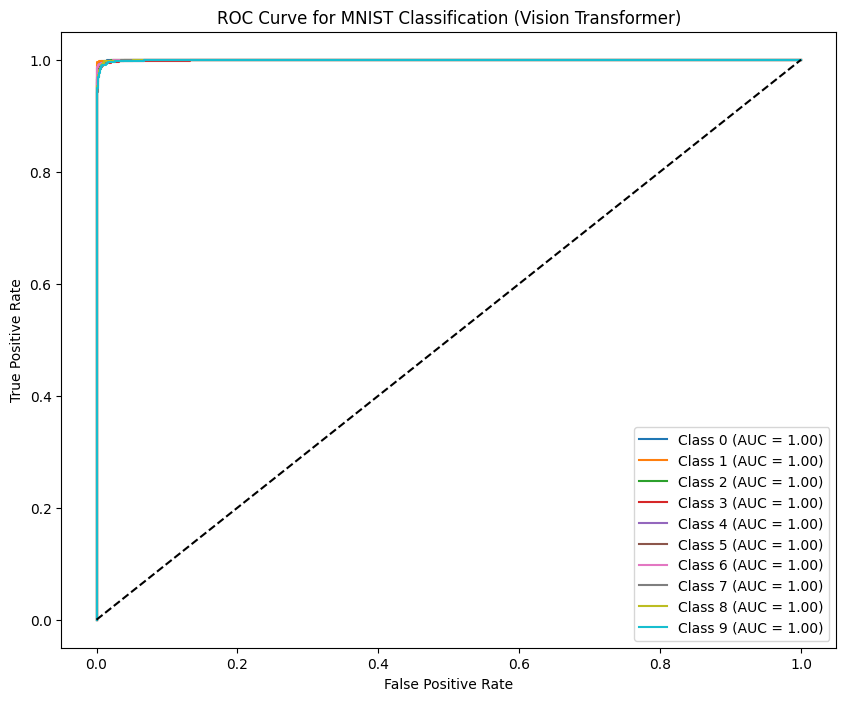

In [16]:
# ROC curve and AUC
model.eval()
all_labels = []
all_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        scores = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        all_labels.extend(labels.cpu().numpy())
        all_scores.extend(scores.cpu().numpy())

all_labels = np.array(all_labels)
all_scores = np.array(all_scores)

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(all_labels == i, all_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MNIST Classification (Vision Transformer)')
plt.legend(loc='lower right')
plt.show()

To convert this classical vision transformer to quantum, we can convert both the patch embedding and transformer encoder to be quantum. There will mostly be 3 quantum parts, patch embedding, QMHA, and QMLP. I will show their rough circuit idea. Below is a rough sketch: 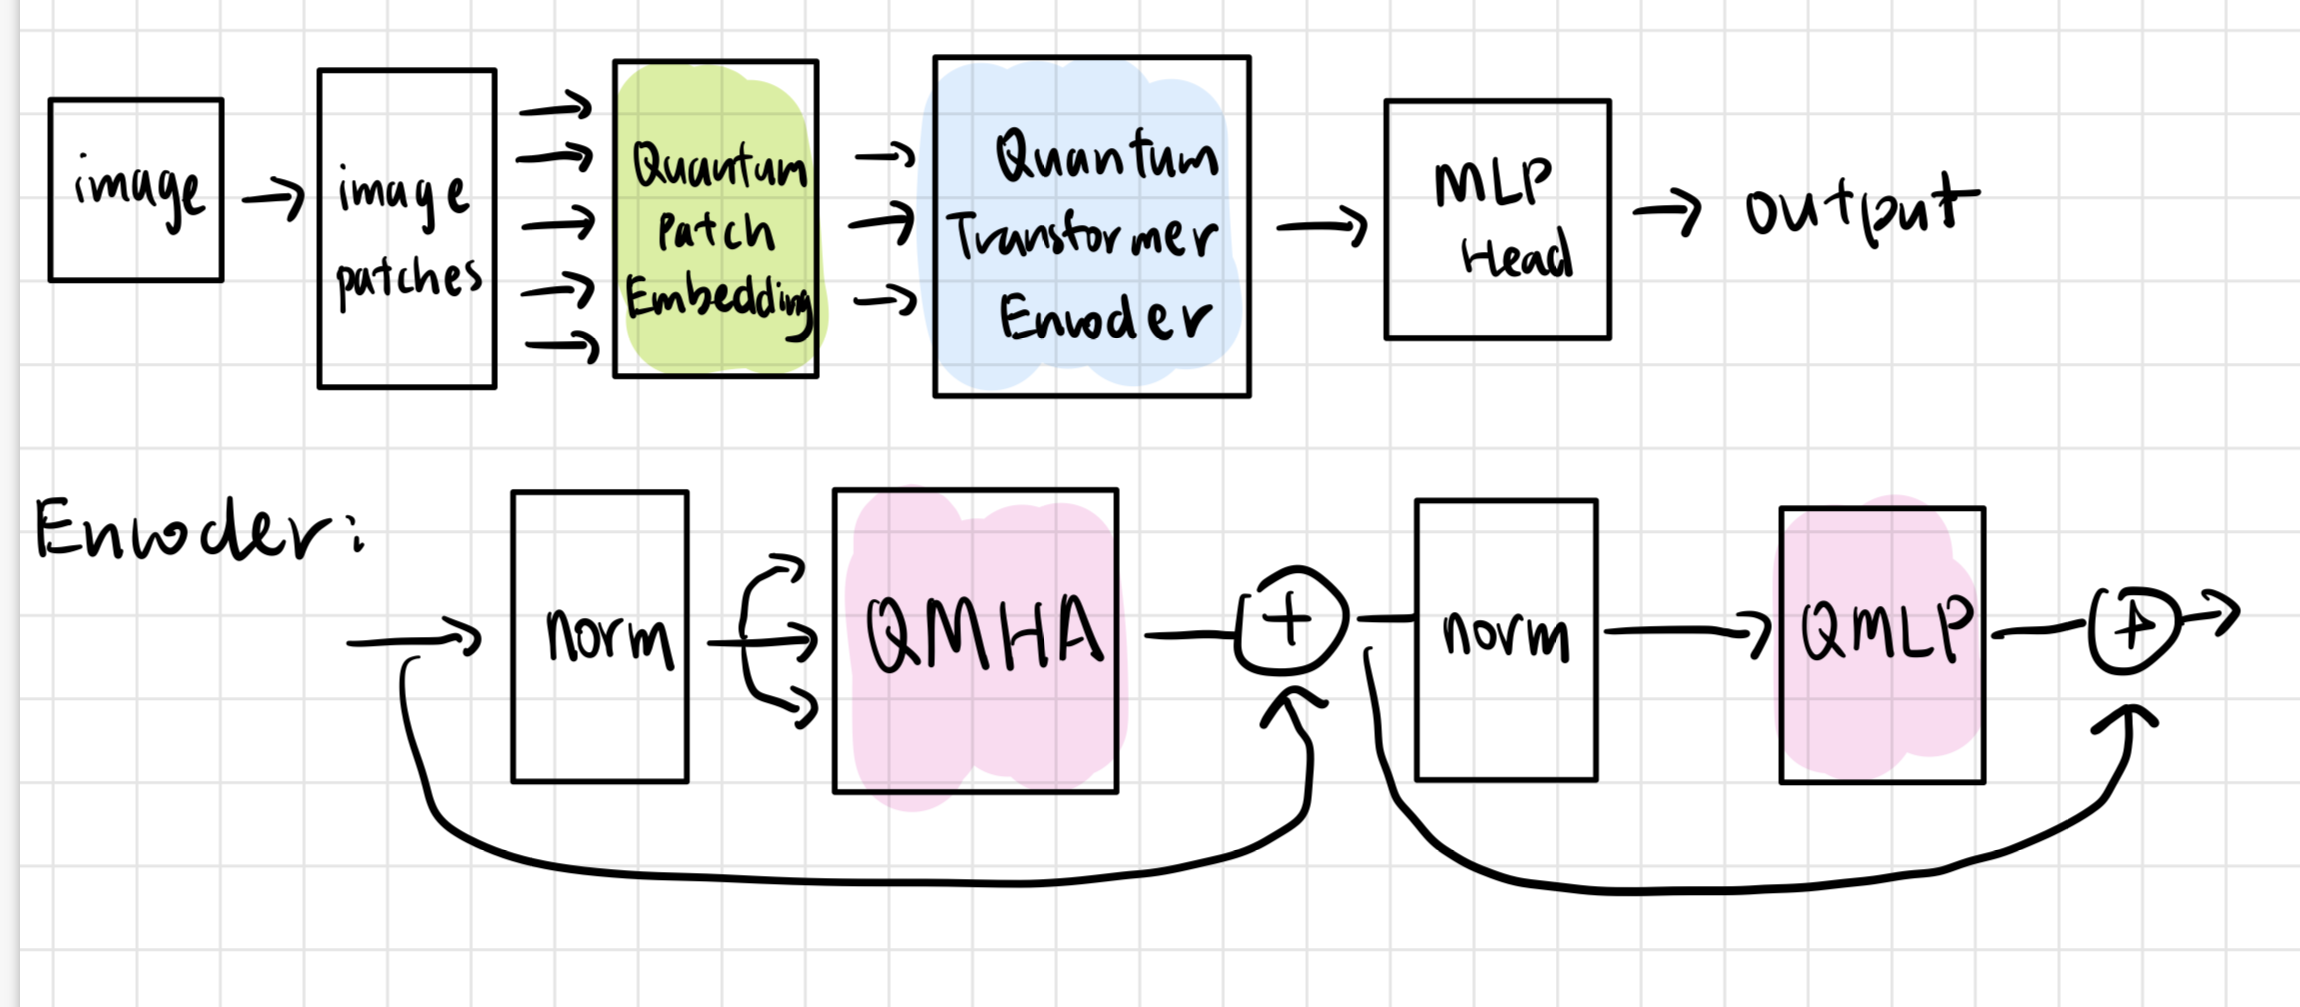

For quantum patch embedding, we can encode the pixel information of each path in qubits. For example, we can use amplitude encoding. Then in this case, we only need 6 qubits to encode a 7x7=49 pixel patch.

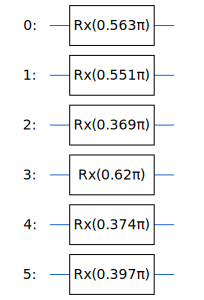

In [12]:
qubits = cirq.LineQubit.range(6)
patch_values = np.random.rand(49)
circuit = cirq.Circuit()
num_qubits = len(qubits)
chunk_size = len(patch_values) // num_qubits

for i, qubit in enumerate(qubits):
    start_idx = i * chunk_size
    if i < num_qubits - 1:
        group = patch_values[start_idx : start_idx + chunk_size]
    else:
        group = patch_values[start_idx:]

    angle = float(np.mean(group))
    angle = angle * np.pi
    circuit.append(cirq.rx(angle)(qubit))

SVGCircuit(circuit)

For QMHA, we will create parallel Variational quantum circuits. Here is an example with two heads and each have 2 layers of trainable parameters:

The two circuits are identical, here is one:


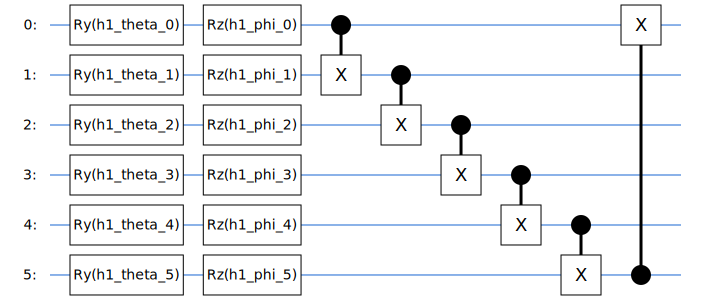

In [21]:
num_heads=2
circuits=[]
for head_idx in range(num_heads):
    circuit = cirq.Circuit()

    # A sub-layer with trainable parameter rotations
    for i, q in enumerate(qubits):
        theta = sympy.Symbol(f"h{head_idx}_theta_{i}")
        circuit.append(cirq.ry(theta)(q))

    # Another layer of param
    for i, q in enumerate(qubits):
        phi = sympy.Symbol(f"h{head_idx}_phi_{i}")
        circuit.append(cirq.rz(phi)(q))

    # circular entanglement
    for i in range(len(qubits)):
        q1 = qubits[i]
        q2 = qubits[(i+1) % len(qubits)]
        circuit.append(cirq.CNOT(q1, q2))
    circuits.append(circuit)
print("The two circuits are identical, here is one:")
SVGCircuit(circuit)

The QMLP Layer can contain some layers of trainable parameter as rotation gates and entanglement through CNOT gate. Below I'm showing an example of 2 layer of parameter and one layer of circular CNOT.

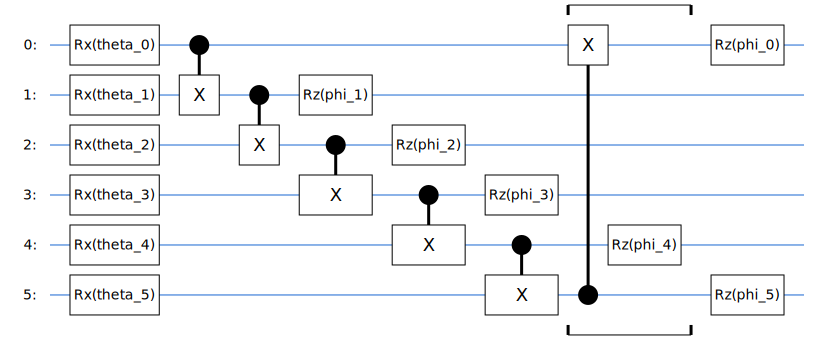

In [11]:
circuit = cirq.Circuit()

# A layer of trainable parameters theta
for i, q in enumerate(qubits):
    theta = sympy.Symbol(f"theta_{i}")
    circuit.append(cirq.rx(theta)(q))

#entanglement through circular CNOT
for i in range(len(qubits)):
        q1 = qubits[i]
        q2 = qubits[(i+1) % len(qubits)]
        circuit.append(cirq.CNOT(q1, q2))

# Another layer trainable parameters phi
for i, q in enumerate(qubits):
    phi = sympy.Symbol(f"phi_{i}")
    circuit.append(cirq.rz(phi)(q))

SVGCircuit(circuit)